<a href="https://colab.research.google.com/github/vishrut2104/cardiac-cycle-tracking/blob/main/final_heart_segmentation(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tracking the motion of heart over a cardiac cycle from Magnetic Resonance images using deep learning.

In this project we will be utilizing the latest image registration (tracking) mechanisms that are deep learning based methods. The student will explore latest literature and implement a suitable neural network that is able to track heart motion given a sequence of CMR images comprising 50 images with a resolution of 128x128. The implementation needs to be efficient and reliable to allow running over a large scaling of existing images.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
import math
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG16



Image shape: (232, 256, 10)


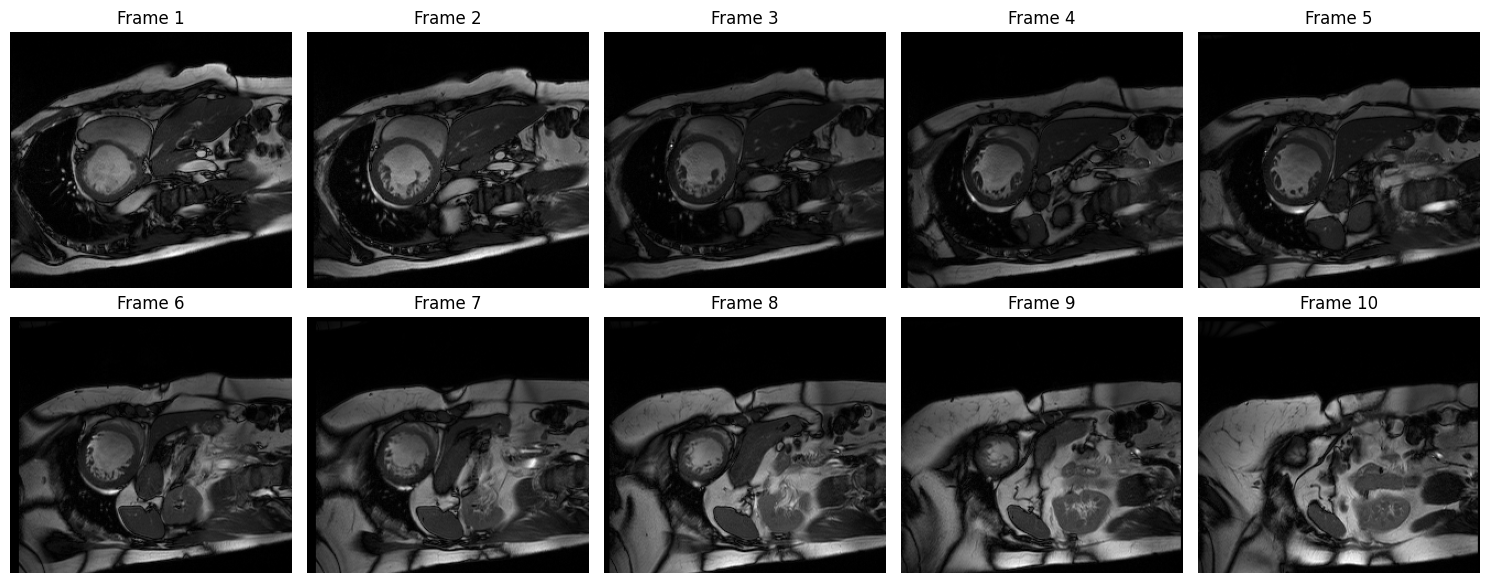

In [ ]:
dataset_dir = '/content/drive/My Drive/UoG/ACDC2/database/training/'
image_path = os.path.join(dataset_dir, 'patient004','patient004_frame01.nii.gz')

image_data = nib.load(image_path).get_fdata()

# Visualise the MRI scan of patient004
num_frames = image_data.shape[2]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(num_frames):
    image_slice = image_data[:, :, i]
    axes[i].imshow(image_slice, cmap='gray')
    axes[i].set_title('Frame {}'.format(i + 1))
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Extract images as well as annotations and store them in data structures

In [ ]:
dataset_dir = '/content/drive/My Drive/UoG/ACDC/database/training/'
frame_count = 11  # Number of frames

# List all patient directories in the dataset folder
patients = [patient for patient in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, patient))]

ring_masks_all_patients = []
images_all_patients = []

for patient in patients:
    patient_dir = os.path.join(dataset_dir, patient)
    patient_files = os.listdir(patient_dir)
    annotation_paths = []
    image_paths = []

    for file in patient_files:
        if file.startswith('patient') and file.endswith('frame01_gt.nii.gz'):
            annotation_paths.append(os.path.join(patient_dir, file))

    for file in patient_files:
        if file.startswith('patient') and file.endswith('frame01.nii.gz'):
            image_paths.append(os.path.join(patient_dir, file))

    patient_masks = []
    for annotation_path in annotation_paths[:frame_count]:
        annotation_data = nib.load(annotation_path).get_fdata()
        ring_label = 2
        ring_mask = np.where(annotation_data == ring_label, 1, 0)
        patient_masks.append(ring_mask)


    patient_images = []
    for image_path in image_paths[:frame_count]:
        image_data = nib.load(image_path).get_fdata()
        patient_images.append(image_data)

    ring_masks_all_patients.append(patient_masks)
    images_all_patients.append(patient_images)

print(len(images_all_patients))
print([len(patient_images) for patient_images in images_all_patients])


##Display the frames of a particular patient along with it's corresponding binary mask

(154, 224, 6)


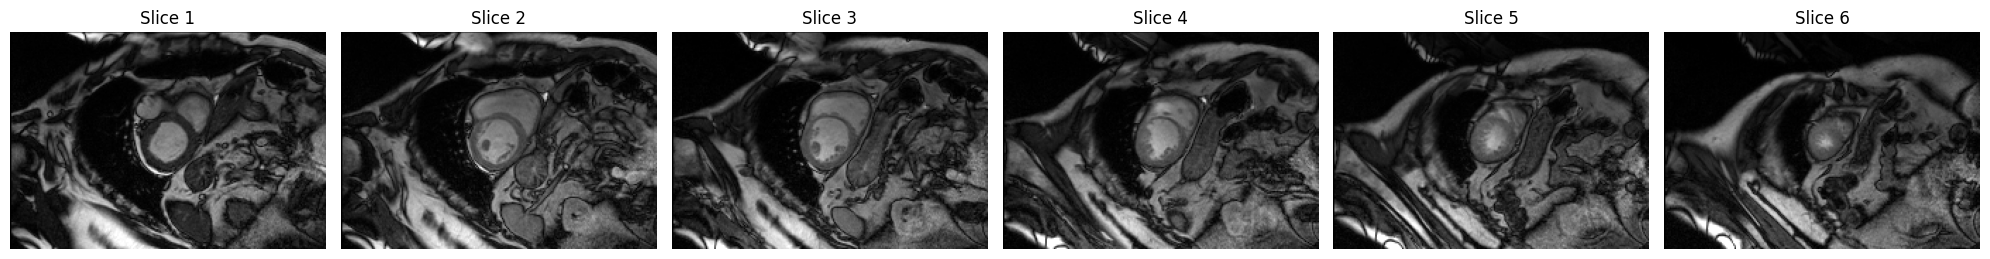

patient_masks[0] shape
(154, 224, 6)


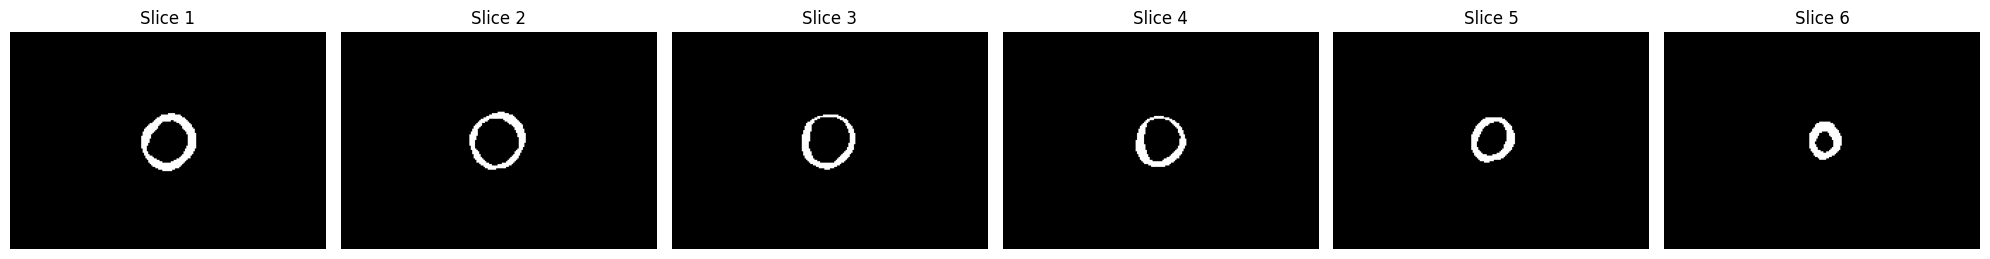

In [ ]:
patient_images = images_all_patients[62]

image_0 = patient_images[0]
num_slices = image_0.shape[2]

fig, axes = plt.subplots(1, num_slices, figsize=(20, 5))

for slice in range(num_slices):
    slice_mask = image_0[:, :, slice]
    axes[slice].imshow(slice_mask, cmap='gray')
    axes[slice].set_title('Slice {}'.format(slice + 1))
    axes[slice].axis('off')

plt.tight_layout()
plt.show()

patient_masks = ring_masks_all_patients[62]
ring_mask_0 = patient_masks[0]
num_slices = ring_mask_0.shape[2]

fig, axes = plt.subplots(1, num_slices, figsize=(20, 5))

for slice in range(num_slices):
    slice_mask = ring_mask_0[:, :, slice]
    axes[slice].imshow(slice_mask, cmap='gray')
    axes[slice].set_title('Slice {}'.format(slice + 1))
    axes[slice].axis('off')

plt.tight_layout()
plt.show()


## Resize Images and Binary masks

In [ ]:
resized_images_all_patients = []
for patient_images in images_all_patients:
    resized_patient_images = []
    for image in patient_images:
        resized_image = cv2.resize(image, (128, 128))
        resized_patient_images.append(resized_image)

    resized_images_all_patients.append(resized_patient_images)

In [ ]:
resized_masks_all_patients = []
for patient_masks in ring_masks_all_patients:
    resized_patient_masks = []
    for mask in patient_masks:
        mask_float32 = mask.astype(np.float32)
        resized_mask = cv2.resize(mask_float32, (128, 128), interpolation=cv2.INTER_LINEAR)
        resized_patient_masks.append(resized_mask)

    resized_masks_all_patients.append(resized_patient_masks)

##Check the resized image and its binary mask


(128, 128, 9)


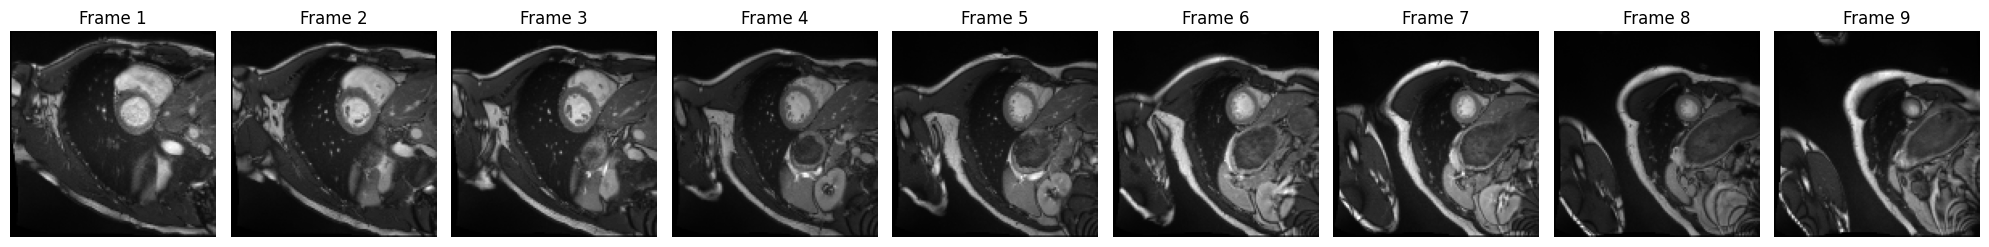

(128, 128, 9)


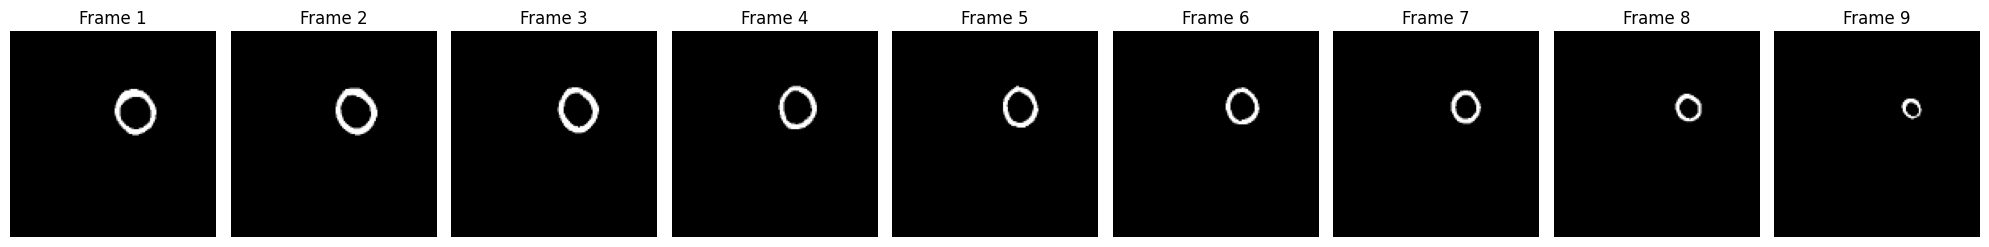

In [ ]:
patient_images = resized_images_all_patients[21]
image_0 = patient_images[0]

num_frames = image_0.shape[2]

fig, axes = plt.subplots(1, num_frames, figsize=(20, 5))

for frame in range(num_frames):
    frame_image = image_0[:, :, frame]
    axes[frame].imshow(frame_image, cmap='gray')
    axes[frame].set_title('Frame {}'.format(frame + 1))
    axes[frame].axis('off')

plt.tight_layout()
plt.show()


patient_masks = resized_masks_all_patients[21]
mask_0 = patient_masks[0]

num_frames = mask_0.shape[2]

fig, axes = plt.subplots(1, num_frames, figsize=(20, 5))
for frame in range(num_frames):
    frame_mask = mask_0[:, :, frame]
    axes[frame].imshow(frame_mask, cmap='gray')
    axes[frame].set_title('Frame {}'.format(frame + 1))
    axes[frame].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
max_pixel_value = -np.inf
for patient_masks in resized_images_all_patients:
    for frame_mask in patient_masks:
        current_max = np.max(frame_mask)
        if current_max > max_pixel_value:
            max_pixel_value = current_max

print("Maximum pixel value from all frame masks:", max_pixel_value)

Maximum pixel value from all frame masks: 3391.59375


In [ ]:
max_pixel_value = -np.inf
for patient_masks in resized_masks_all_patients:
    for frame_mask in patient_masks:
        current_max = np.max(frame_mask)
        if current_max > max_pixel_value:
            max_pixel_value = current_max

print("Maximum pixel value from all frame masks:", max_pixel_value)

Maximum pixel value from all frame masks: 1.0


#Normalising resized images as the masks are already normalised

In [ ]:
max_pixel_value = 3391.59375
normalized_images = []

for patient_images in resized_images_all_patients:
    normalized_frames = []
    for frame in patient_images:
        normalized_frame = frame / max_pixel_value
        normalized_frames.append(normalized_frame)
    normalized_images.append(normalized_frames)

normalized_images = np.array(normalized_images)


<ipython-input-7-7c250959152c>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  normalized_images = np.array(normalized_images)


In [ ]:
max_pixel_value = -np.inf
for patient_masks in normalized_images:
    for frame_mask in patient_masks:
        current_max = np.max(frame_mask)
        if current_max > max_pixel_value:
            max_pixel_value = current_max

print("Maximum pixel value from all frame masks:", max_pixel_value)

Maximum pixel value from all frame masks: 1.0


#Truncate all images and masks to keep the best 6 frames

Due to our limited GPU sources and time, we will continue our work on just 6 frames of each patient.

#Truncate function for masks


In [ ]:
num_mid_frames_to_keep = 4
best_masks_all_patients = []

for patient_masks_outer in resized_masks_all_patients:
    best_frames_masks_patient = []

    for patient_masks in patient_masks_outer:
        num_frames = patient_masks.shape[2]
        step_size = math.ceil((num_frames - 2) / (num_mid_frames_to_keep))

        if(num_frames > 7 and step_size >1):
          step_size = max(2,step_size)
        else:
          step_size = math.ceil((num_frames - 2) // (num_mid_frames_to_keep))

        mid_frame_indices_to_keep = list(range(1, num_frames, step_size))[:num_mid_frames_to_keep]
        indices_to_keep = [0] + mid_frame_indices_to_keep + [num_frames - 1]

        best_frames_masks = patient_masks[:, :, indices_to_keep]
        best_frames_masks_patient.append(best_frames_masks)

    best_masks_all_patients.append(best_frames_masks_patient)

In [ ]:
for patient_masks in best_masks_all_patients:
    for frame_mask in patient_masks:
        print(frame_mask.shape)

(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 

#Truncate function for normalised images

In [ ]:
num_mid_frames_to_keep = 4
best_images_all_patients = []

for patient_images_outer in normalized_images:
    best_frames_images_patient = []

    for patient_images in patient_images_outer:
        num_frames = patient_images.shape[2]
        step_size = math.ceil((num_frames - 2) / (num_mid_frames_to_keep))

        if(num_frames > 7 and step_size >1):
          step_size = max(2,step_size)
        else:
          step_size = math.ceil((num_frames - 2) // (num_mid_frames_to_keep))

        mid_frame_indices_to_keep = list(range(1, num_frames, step_size))[:num_mid_frames_to_keep]
        indices_to_keep = [0] + mid_frame_indices_to_keep + [num_frames - 1]

        best_frames_images = patient_images[:, :, indices_to_keep]
        best_frames_images_patient.append(best_frames_images)

    best_images_all_patients.append(best_frames_images_patient)

In [ ]:
for patient_masks in best_images_all_patients:
    for frame_mask in patient_masks:
        print(frame_mask.shape)

(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 128, 6)
(128, 

(128, 128, 6)


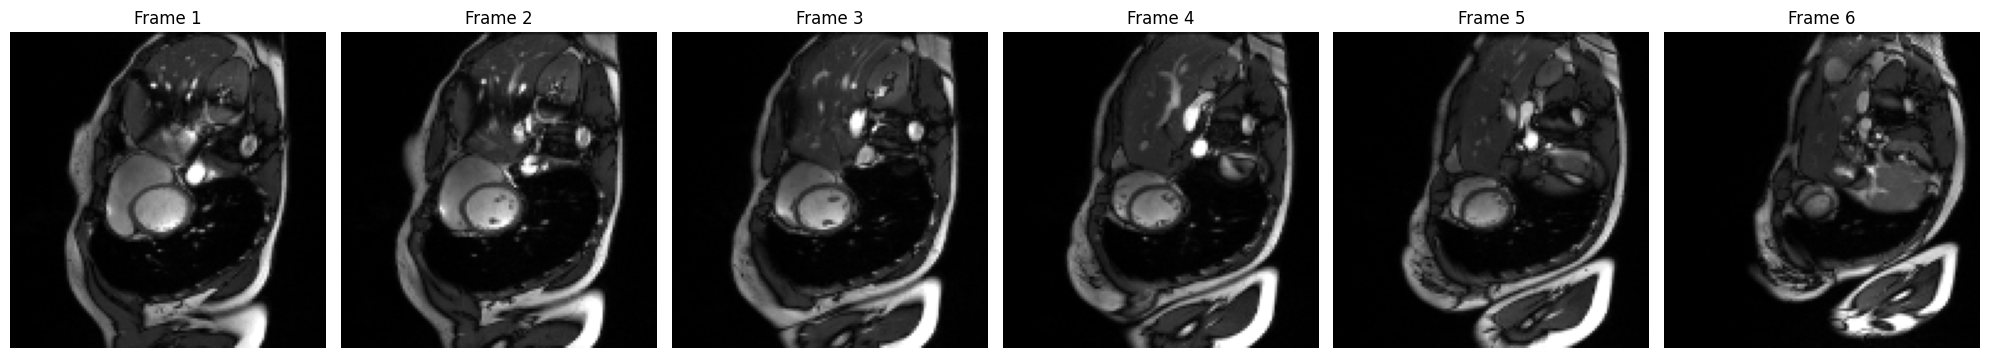

(128, 128, 6)


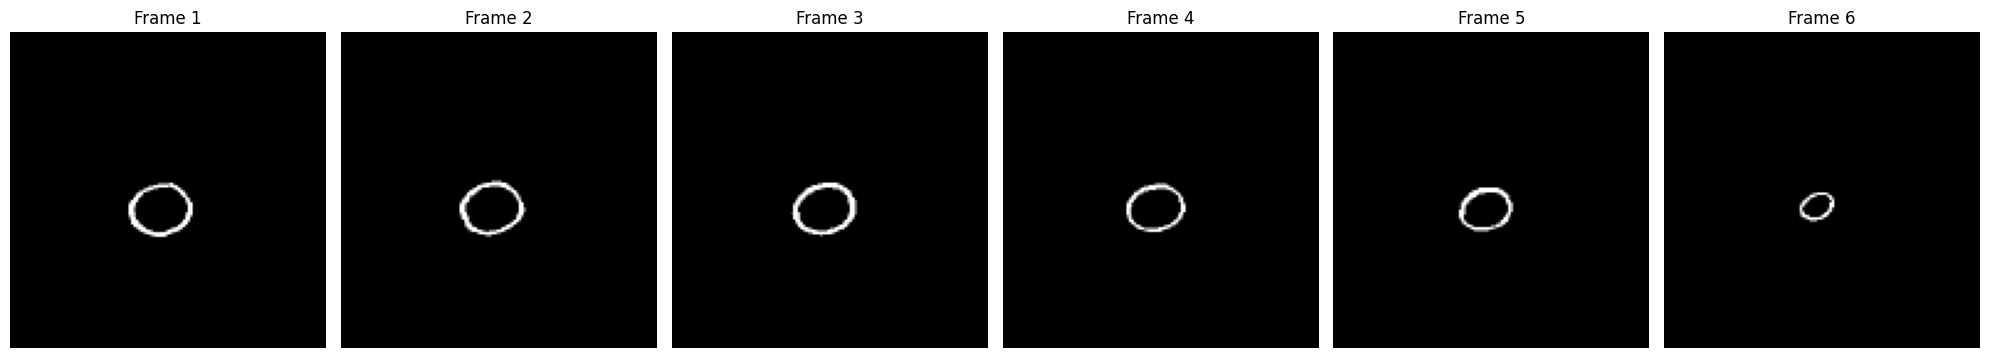

In [ ]:
patient_images = best_images_all_patients[32]

image_0 = patient_images[0]
num_frames = image_0.shape[2]

fig, axes = plt.subplots(1, num_frames, figsize=(20, 5))

for frame in range(num_frames):
    frame_image = image_0[:, :, frame]
    axes[frame].imshow(frame_image, cmap='gray')
    axes[frame].set_title('Frame {}'.format(frame + 1))
    axes[frame].axis('off')

plt.tight_layout()
plt.show()


patient_masks = best_masks_all_patients[32]

mask_0 = patient_masks[0]
num_frames = mask_0.shape[2]

fig, axes = plt.subplots(1, num_frames, figsize=(20, 5))
for frame in range(num_frames):
    frame_mask = mask_0[:, :, frame]
    axes[frame].imshow(frame_mask, cmap='gray')
    axes[frame].set_title('Frame {}'.format(frame + 1))
    axes[frame].axis('off')

plt.tight_layout()
plt.show()

#Removing the nested lists from our datasets

In [ ]:
input_data_images=[]
input_data_masks=[]
for patient_masks in best_images_all_patients:
    for frame_mask in patient_masks:
        input_data_images.append(frame_mask)

for patient_masks in best_masks_all_patients:
    for frame_mask in patient_masks:
        input_data_masks.append(frame_mask)

#Changing data shape to fit the pretrained Unet model

In [ ]:
expanded_images_data = []
for data_point in input_data_images:
    for frame in data_point.transpose(2, 0, 1):
        new_data_point = np.repeat(frame[:, :, np.newaxis], 3, axis=-1)
        expanded_images_data.append(new_data_point)

expanded_images_data = np.array(expanded_images_data)

In [ ]:
expanded_masks_data = []
for data_point in input_data_masks:
    for frame in data_point.transpose(2, 0, 1):
        new_data_point = np.repeat(frame[:, :, np.newaxis], 3, axis=-1)
        expanded_masks_data.append(new_data_point)

expanded_masks_data = np.array(expanded_masks_data)

In [ ]:
for i in expanded_masks_data:
  print(i.shape)
print(len(expanded_masks_data))

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

In [ ]:
for i in expanded_images_data:
  print(i.shape)
print(len(expanded_images_data))

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

#Splitting the data

In [ ]:
images_data = np.array(expanded_images_data)
masks_data = np.array(expanded_masks_data)

In [ ]:
print(images_data.shape)

(594, 128, 128, 3)


In [ ]:
np.save('/content/drive/My Drive/UoG/images_data.npy', images_data)
np.save('/content/drive/My Drive/UoG/masks_data.npy', masks_data)

In [ ]:
np.save('/content/drive/My Drive/UoG/input_data_images.npy', input_data_images)
np.save('/content/drive/My Drive/UoG/input_data_masks.npy', input_data_masks)

In [ ]:
split_ratio = 0.8
split_index = int(len(images_data) * split_ratio)

train_images, val_images, train_masks, val_masks = train_test_split(images_data, masks_data, test_size=0.2, random_state=42)

#Defining A U-net Model

In [ ]:

def unet_model(input_shape, learning_rate):
    inputs = tf.keras.Input(shape=input_shape)


    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(conv3)

    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.Conv2D(128, 2, activation="relu", padding="same")(up1)
    merge1 = layers.concatenate([conv2, up1], axis=-1)
    conv4 = layers.Conv2D(128, 3, activation="relu", padding="same")(merge1)
    conv4 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv4)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    up2 = layers.Conv2D(64, 2, activation="relu", padding="same")(up2)
    merge2 = layers.concatenate([conv1, up2], axis=-1)
    conv5 = layers.Conv2D(64, 3, activation="relu", padding="same")(merge2)
    conv5 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv5)

    outputs = layers.Conv2D(6, 1, activation="sigmoid")(conv5)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy")

    return model

input_shape = train_images.shape[1:]
learning_rate = 0.0005
model = unet_model(input_shape, learning_rate=learning_rate)
model.compile(optimizer="adam", loss="binary_crossentropy")



In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_26 (Conv2D)             (None, 128, 128, 64  3520        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_27 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_26[0][0]']              
                                )                                                           

#training first large model

In [ ]:
epochs = 50
batch_size = 4

history = model.fit(train_images, train_masks, batch_size=batch_size, epochs=epochs, validation_data=(val_images, val_masks))

Epoch 1/50
20/20 [==============================] - 8s 231ms/step - loss: 0.0374 - val_loss: 0.0461
Epoch 2/50
20/20 [==============================] - 1s 53ms/step - loss: 0.0351 - val_loss: 0.0484
Epoch 3/50
20/20 [==============================] - 1s 56ms/step - loss: 0.0334 - val_loss: 0.0531
Epoch 4/50
20/20 [==============================] - 1s 52ms/step - loss: 0.0357 - val_loss: 0.0573
Epoch 5/50
20/20 [==============================] - 1s 51ms/step - loss: 0.0324 - val_loss: 0.0415
Epoch 6/50
20/20 [==============================] - 1s 51ms/step - loss: 0.0294 - val_loss: 0.0447
Epoch 7/50
20/20 [==============================] - 1s 51ms/step - loss: 0.0289 - val_loss: 0.0411
Epoch 8/50
20/20 [==============================] - 1s 51ms/step - loss: 0.0276 - val_loss: 0.0367
Epoch 9/50
20/20 [==============================] - 1s 50ms/step - loss: 0.0266 - val_loss: 0.0369
Epoch 10/50
20/20 [==============================] - 1s 55ms/step - loss: 0.0258 - val_loss: 0.0360
Epoch 11

1/1 [==============================] - 0s 27ms/step


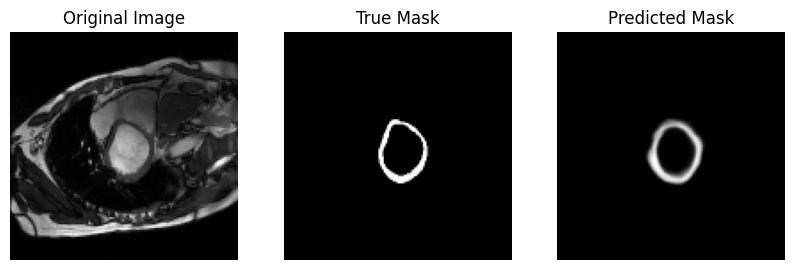

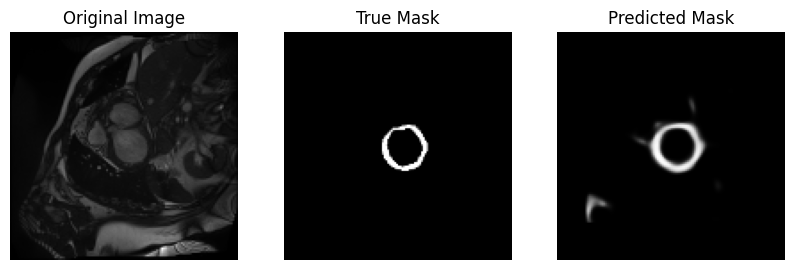

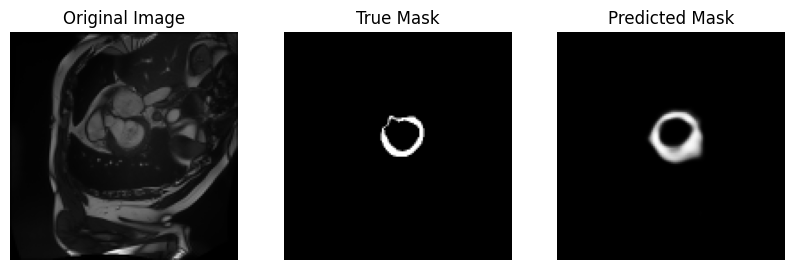

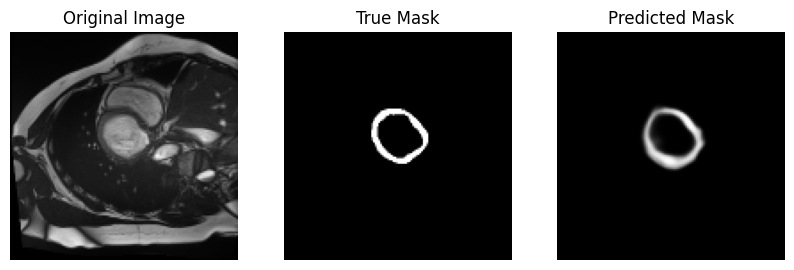

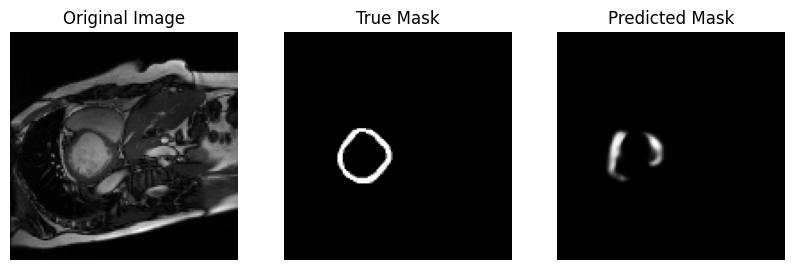

In [ ]:
predicted_masks = model.predict(val_images)

num_samples = 5
sample_indices = np.random.choice(len(val_images), num_samples, replace=False)

for idx in sample_indices:
    original_image = val_images[idx]
    true_mask = val_masks[idx]
    predicted_mask = predicted_masks[idx]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[..., 0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask[..., 0], cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[..., 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

In [ ]:
model.save("/content/drive/My Drive/UoG/model_zoo/model_2")

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/My Drive/UoG/model_zoo/model_2")

In [ ]:
predicted_masks = loaded_model.predict(val_images)

1/1 [==============================] - 10s 10s/step


In [ ]:
smooth = 1e-5
sum_dice = 0.0

for index in range(len(predicted_masks)):
    y_pred = predicted_masks[index]
    y_true = val_masks[index]
    flattened_y_pred = tf.keras.backend.flatten(y_pred)
    flattened_y_true = tf.keras.backend.flatten(y_true)

    intersection = tf.keras.backend.sum(flattened_y_pred * flattened_y_true)
    dice = (2.0 * intersection + smooth) / (tf.keras.backend.sum(flattened_y_true) + tf.keras.backend.sum(flattened_y_pred) + smooth)
    sum_dice += dice

avg_dice = sum_dice / len(predicted_masks)
print("Average Dice Score:", avg_dice)

Average Dice Score: tf.Tensor(0.48752683, shape=(), dtype=float32)


In [ ]:
train_images.shape

(475, 128, 128, 3)

#Defining a pretrained U-net Model

In [ ]:

def conv_block(input, num_filters, kernel_size=3, strides=1, padding="same"):
    x = Conv2D(num_filters, kernel_size, strides=strides, padding=padding)(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def decoder_block(input, skip_features, num_filters, kernel_size=3, strides=2):
    x = Conv2DTranspose(num_filters, kernel_size, strides=strides, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def dice_coefficient(y_true, y_pred):
    smooth = 1e-5
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice = (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def build_custom_vgg16_unet(input_shape):
    inputs = Input(input_shape)

    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    s1 = vgg16.get_layer("block1_conv2").output
    s2 = vgg16.get_layer("block2_conv2").output
    s3 = vgg16.get_layer("block3_conv3").output
    s4 = vgg16.get_layer("block4_conv3").output

    b1 = vgg16.get_layer("block5_conv3").output

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")

    learning_rate = 0.0005
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=dice_loss, metrics=[dice_coefficient])

    def lr_decay(epoch, lr):
        decay_rate = 0.98
        return lr * decay_rate

    lr_scheduler = LearningRateScheduler(lr_decay)

    return model, lr_scheduler

if __name__ == "__main__":
    input_shape = (128, 128, 3)
    model, lr_scheduler = build_custom_vgg16_unet(input_shape)
    model.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                       

In [ ]:
learning_rate = 0.0005
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy')

def lr_decay(epoch, lr):
    decay_rate = 0.98
    return lr * decay_rate

lr_scheduler = LearningRateScheduler(lr_decay)

batch_size = 32
epochs = 50
history = model.fit(train_images, train_masks, batch_size=batch_size, epochs=epochs,
                    validation_data=(val_images, val_masks), callbacks=[lr_scheduler])



Epoch 1/50
15/15 [==============================] - 16s 451ms/step - loss: 0.0257 - val_loss: 0.0951 - lr: 4.9000e-04
Epoch 2/50
15/15 [==============================] - 7s 437ms/step - loss: 0.0174 - val_loss: 0.0371 - lr: 4.8020e-04
Epoch 3/50
15/15 [==============================] - 7s 437ms/step - loss: 0.0140 - val_loss: 0.0163 - lr: 4.7060e-04
Epoch 4/50
15/15 [==============================] - 6s 423ms/step - loss: 0.0124 - val_loss: 0.0355 - lr: 4.6118e-04
Epoch 5/50
15/15 [==============================] - 6s 419ms/step - loss: 0.0103 - val_loss: 0.0321 - lr: 4.5196e-04
Epoch 6/50
15/15 [==============================] - 6s 410ms/step - loss: 0.0091 - val_loss: 0.0346 - lr: 4.4292e-04
Epoch 7/50
15/15 [==============================] - 6s 417ms/step - loss: 0.0083 - val_loss: 0.0271 - lr: 4.3406e-04
Epoch 8/50
15/15 [==============================] - 6s 399ms/step - loss: 0.0079 - val_loss: 0.0290 - lr: 4.2538e-04
Epoch 9/50
15/15 [==============================] - 6s 400ms/st

In [ ]:

evaluation = model.evaluate(val_images, val_masks)
print("Loss:", evaluation)
print("Dice Coefficient:", evaluation)


4/4 [==============================] - 1s 119ms/step - loss: 0.0154
Loss: 0.015368223190307617
Dice Coefficient: 0.015368223190307617


4/4 [==============================] - 1s 138ms/step


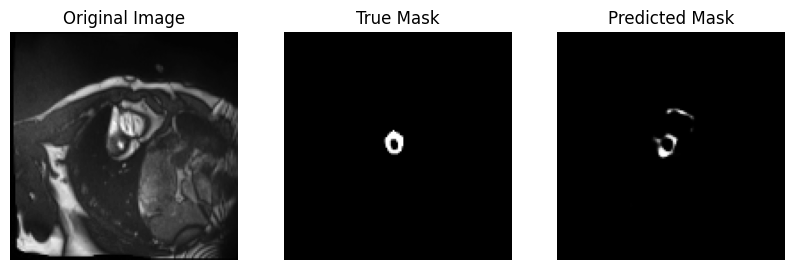

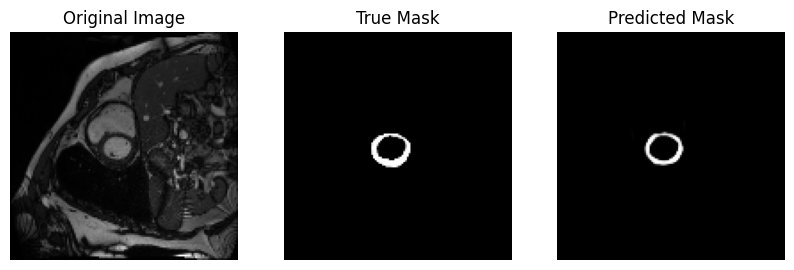

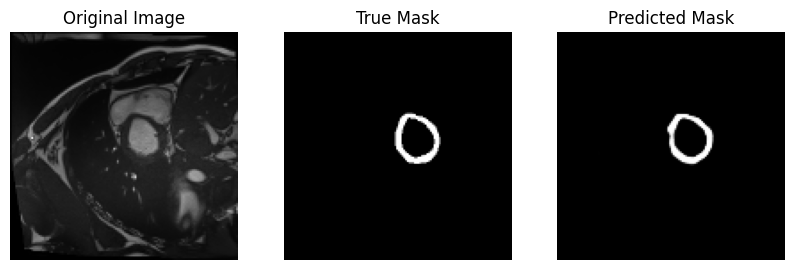

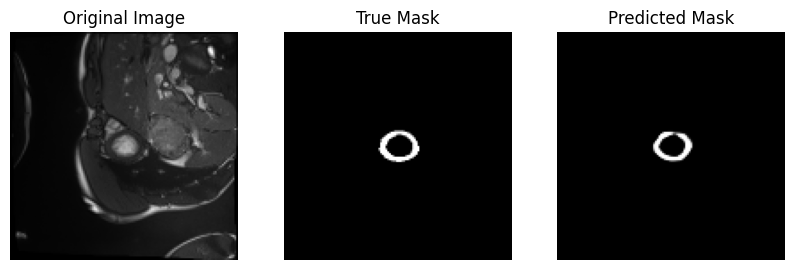

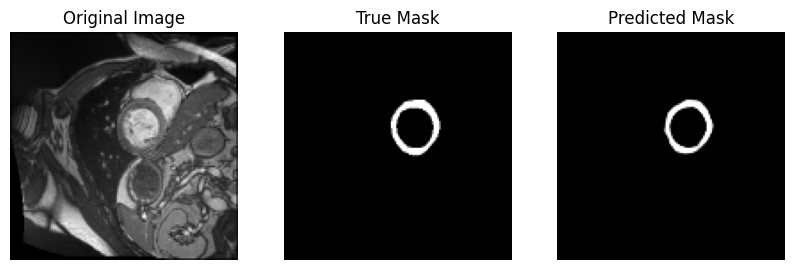

In [ ]:
predicted_masks = model.predict(val_images)

num_samples = 5
sample_indices = np.random.choice(len(val_images), num_samples, replace=False)

for idx in sample_indices:
    original_image = val_images[idx]
    true_mask = val_masks[idx]

    predicted_mask = predicted_masks[idx]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[..., 0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask[..., 0], cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[..., 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

Even though the predictions are much better visually, lets train the model further to see if there is any improvement in the predictions

In [ ]:
epochs = 50
history = model.fit(train_images, train_masks, batch_size=batch_size, epochs=epochs,
                    validation_data=(val_images, val_masks), callbacks=[lr_scheduler])

evaluation = model.evaluate(val_images, val_masks)
print("Loss:", evaluation)
print("Dice Coefficient:", evaluation)


Epoch 1/50
15/15 [==============================] - 6s 424ms/step - loss: 0.0038 - val_loss: 0.0156 - lr: 1.7844e-04
Epoch 2/50
15/15 [==============================] - 6s 429ms/step - loss: 0.0038 - val_loss: 0.0157 - lr: 1.7487e-04
Epoch 3/50
15/15 [==============================] - 6s 433ms/step - loss: 0.0039 - val_loss: 0.0157 - lr: 1.7138e-04
Epoch 4/50
15/15 [==============================] - 7s 439ms/step - loss: 0.0039 - val_loss: 0.0161 - lr: 1.6795e-04
Epoch 5/50
15/15 [==============================] - 6s 427ms/step - loss: 0.0040 - val_loss: 0.0152 - lr: 1.6459e-04
Epoch 6/50
15/15 [==============================] - 6s 418ms/step - loss: 0.0039 - val_loss: 0.0160 - lr: 1.6130e-04
Epoch 7/50
15/15 [==============================] - 6s 409ms/step - loss: 0.0038 - val_loss: 0.0157 - lr: 1.5807e-04
Epoch 8/50
15/15 [==============================] - 6s 404ms/step - loss: 0.0037 - val_loss: 0.0156 - lr: 1.5491e-04
Epoch 9/50
15/15 [==============================] - 6s 399ms/ste

4/4 [==============================] - 0s 127ms/step


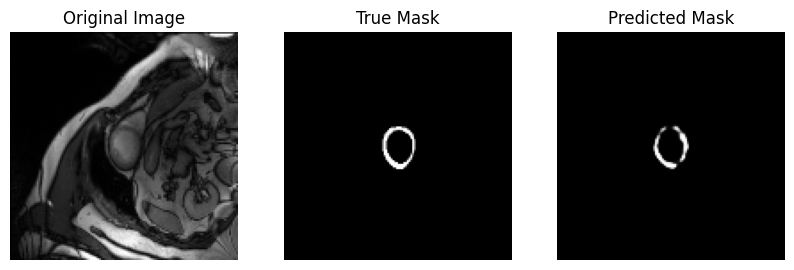

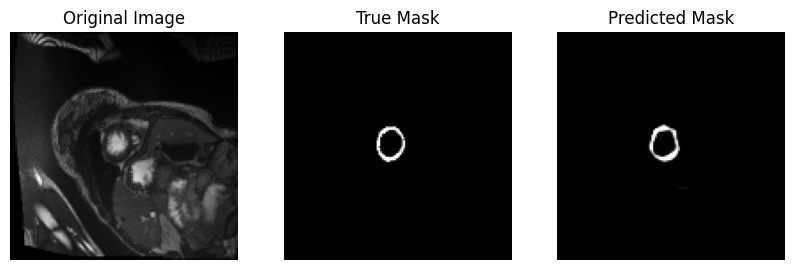

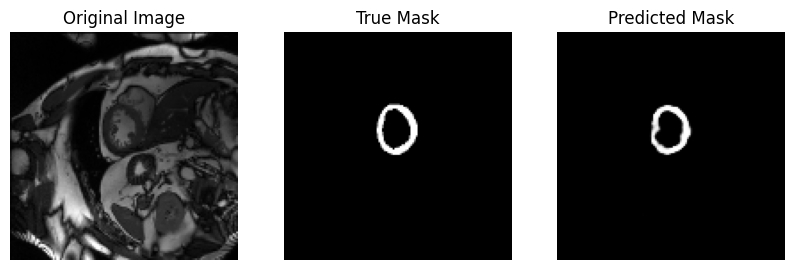

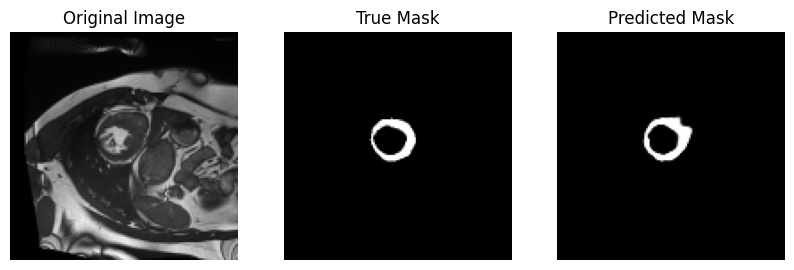

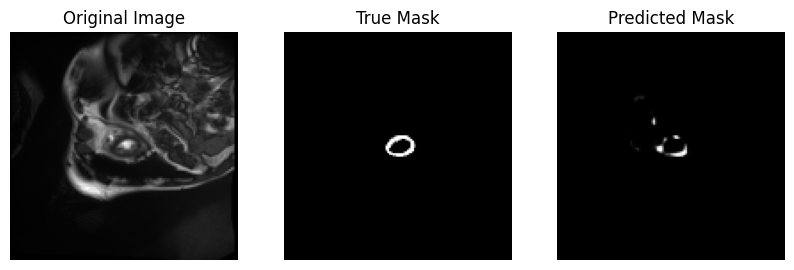

In [ ]:
predicted_masks = model.predict(val_images)

num_samples = 5
sample_indices = np.random.choice(len(val_images), num_samples, replace=False)

for idx in sample_indices:
    original_image = val_images[idx]
    true_mask = val_masks[idx]

    predicted_mask = predicted_masks[idx]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[..., 0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask[..., 0], cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[..., 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

In [ ]:
learning_rate = 0.0005
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=dice_loss, metrics=[dice_coefficient])

evaluation = model.evaluate(val_images, val_masks)
print("Loss:", evaluation[0])
print("Dice Coefficient:", evaluation[1])

4/4 [==============================] - 1s 123ms/step - loss: 0.2331 - dice_coefficient: 0.7669
Loss: 0.23310475051403046
Dice Coefficient: 0.7668868899345398


In [ ]:
history = model.fit(train_images, train_masks, batch_size=batch_size, epochs=epochs,
                    validation_data=(val_images, val_masks), callbacks=[lr_scheduler])

evaluation = model.evaluate(val_images, val_masks)
print("Loss:", evaluation[0])
print("Dice Coefficient:", evaluation[1])


Epoch 1/50
15/15 [==============================] - 16s 425ms/step - loss: 0.2571 - dice_coefficient: 0.7434 - val_loss: 0.6832 - val_dice_coefficient: 0.3121 - lr: 4.9000e-04
Epoch 2/50
15/15 [==============================] - 6s 423ms/step - loss: 0.1750 - dice_coefficient: 0.8254 - val_loss: 0.4108 - val_dice_coefficient: 0.5884 - lr: 4.8020e-04
Epoch 3/50
15/15 [==============================] - 6s 422ms/step - loss: 0.1368 - dice_coefficient: 0.8635 - val_loss: 0.3604 - val_dice_coefficient: 0.6383 - lr: 4.7060e-04
Epoch 4/50
15/15 [==============================] - 6s 430ms/step - loss: 0.1149 - dice_coefficient: 0.8853 - val_loss: 0.2824 - val_dice_coefficient: 0.7175 - lr: 4.6118e-04
Epoch 5/50
15/15 [==============================] - 6s 411ms/step - loss: 0.1018 - dice_coefficient: 0.8982 - val_loss: 0.2927 - val_dice_coefficient: 0.7065 - lr: 4.5196e-04
Epoch 6/50
15/15 [==============================] - 6s 411ms/step - loss: 0.0945 - dice_coefficient: 0.9055 - val_loss: 0.25

In [ ]:
predictions = model.predict(val_images)

4/4 [==============================] - 1s 138ms/step


In [ ]:
threshold = 0.5
binary_predictions = (predictions > threshold).astype('float32')

test_masks_flat = val_masks.flatten()
binary_predictions_flat = binary_predictions.flatten()

dice_score = dice_coefficient(test_masks_flat, binary_predictions_flat)
print("Dice Coefficient on Test Data:", dice_score)

Dice Coefficient on Test Data: tf.Tensor(0.7957886, shape=(), dtype=float32)


4/4 [==============================] - 1s 145ms/step


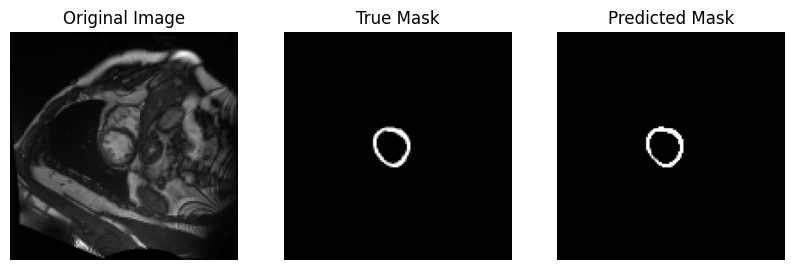

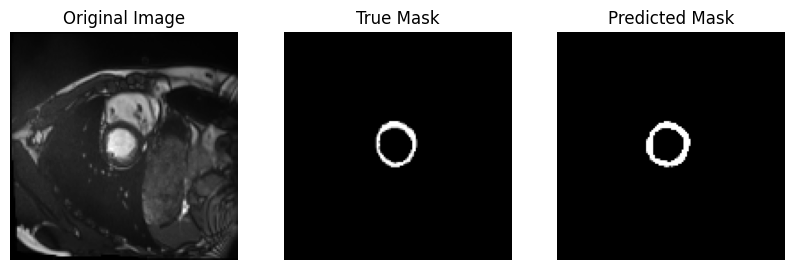

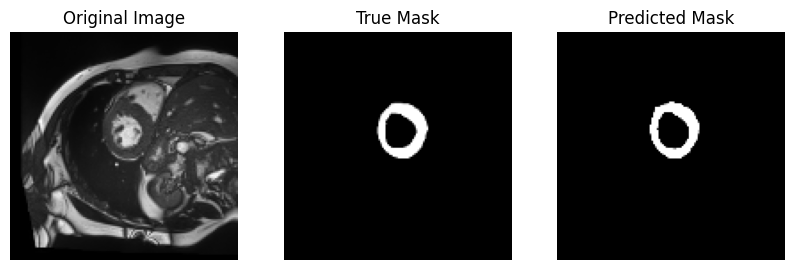

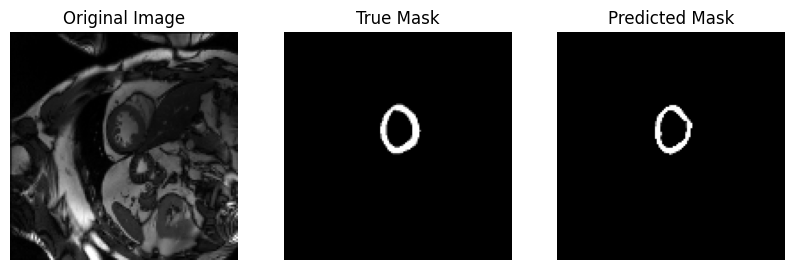

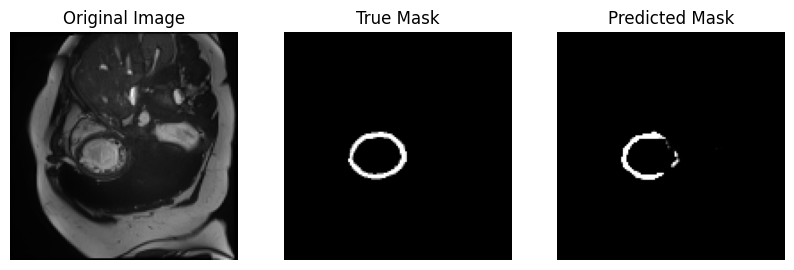

In [ ]:
predicted_masks = model.predict(val_images)

num_samples = 5
sample_indices = np.random.choice(len(val_images), num_samples, replace=False)

for idx in sample_indices:
    original_image = val_images[idx]
    true_mask = val_masks[idx]
    predicted_mask = predicted_masks[idx]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[..., 0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask[..., 0], cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[..., 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

In [ ]:
epochs = 10 #(50+10, run on the same cell)
batch_size = 32
history = model.fit(train_images, train_masks, batch_size=batch_size, epochs=epochs,
                    validation_data=(val_images, val_masks), callbacks=[lr_scheduler])

evaluation = model.evaluate(val_images, val_masks)
print("Loss:", evaluation[0])
print("Dice Coefficient:", evaluation[1])

Epoch 1/10
15/15 [==============================] - 6s 412ms/step - loss: 0.0652 - dice_coefficient: 0.9347 - val_loss: 0.2037 - val_dice_coefficient: 0.7962 - lr: 6.4984e-05
Epoch 2/10
15/15 [==============================] - 6s 426ms/step - loss: 0.0652 - dice_coefficient: 0.9349 - val_loss: 0.2042 - val_dice_coefficient: 0.7956 - lr: 6.3684e-05
Epoch 3/10
15/15 [==============================] - 6s 436ms/step - loss: 0.0652 - dice_coefficient: 0.9349 - val_loss: 0.2041 - val_dice_coefficient: 0.7957 - lr: 6.2410e-05
Epoch 4/10
15/15 [==============================] - 7s 447ms/step - loss: 0.0653 - dice_coefficient: 0.9347 - val_loss: 0.2042 - val_dice_coefficient: 0.7956 - lr: 6.1162e-05
Epoch 5/10
15/15 [==============================] - 6s 426ms/step - loss: 0.0651 - dice_coefficient: 0.9349 - val_loss: 0.2038 - val_dice_coefficient: 0.7960 - lr: 5.9939e-05
Epoch 6/10
15/15 [==============================] - 6s 427ms/step - loss: 0.0652 - dice_coefficient: 0.9348 - val_loss: 0.203

4/4 [==============================] - 0s 130ms/step


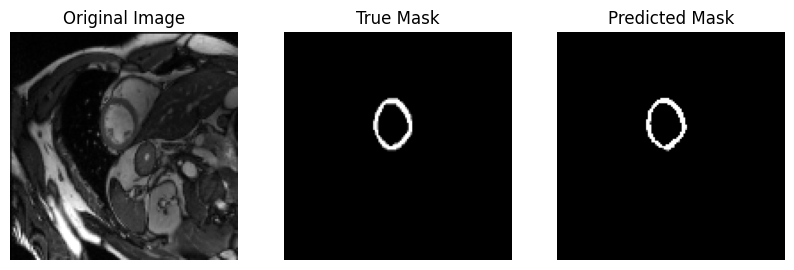

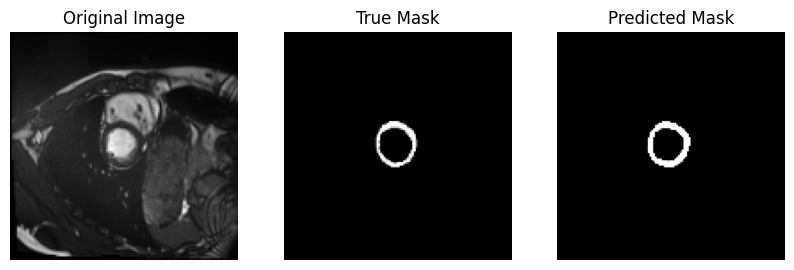

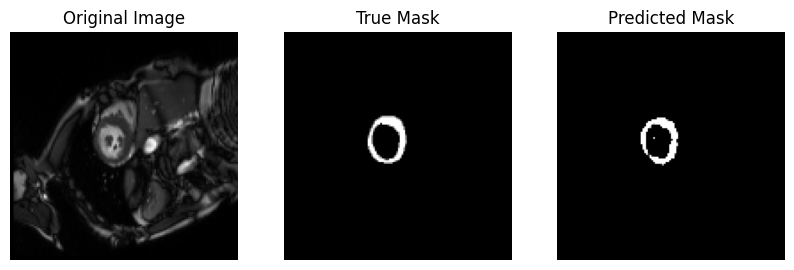

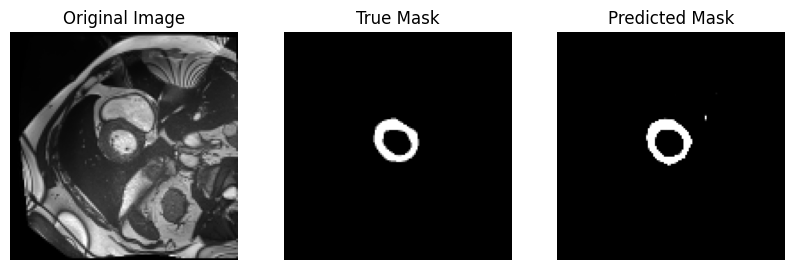

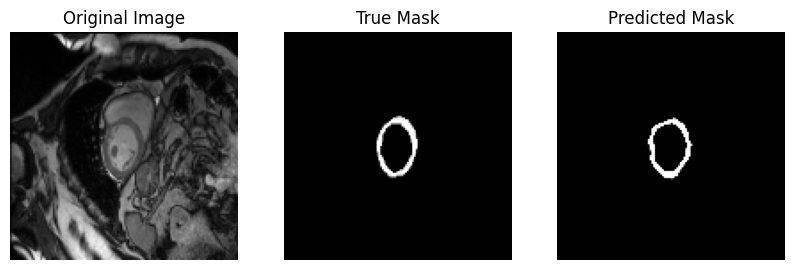

In [ ]:
predicted_masks = model.predict(val_images)

num_samples = 5
sample_indices = np.random.choice(len(val_images), num_samples, replace=False)

for idx in sample_indices:
    original_image = val_images[idx]
    true_mask = val_masks[idx]
    predicted_mask = predicted_masks[idx]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[..., 0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask[..., 0], cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[..., 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

In [ ]:
np.save('/content/drive/My Drive/UoG/predicted_masks.npy', predicted_masks)

In [ ]:
loaded_predicted_masks = np.load('/content/drive/My Drive/UoG/predicted_masks.npy')